# Lab 1 Evaluation

Names, Surnames, and Group : (to complete by 2 students)

In [ ]:
Mocquais Ludovic
Sarr Mariétou

In the following, we consider the  (binarized) Compas dataset that we studied in the Lab

A decision tree configuration is a set of parameters that one can use to build decision trees. Propose 6 configurations that are likely to provide different topologies and caracteristics

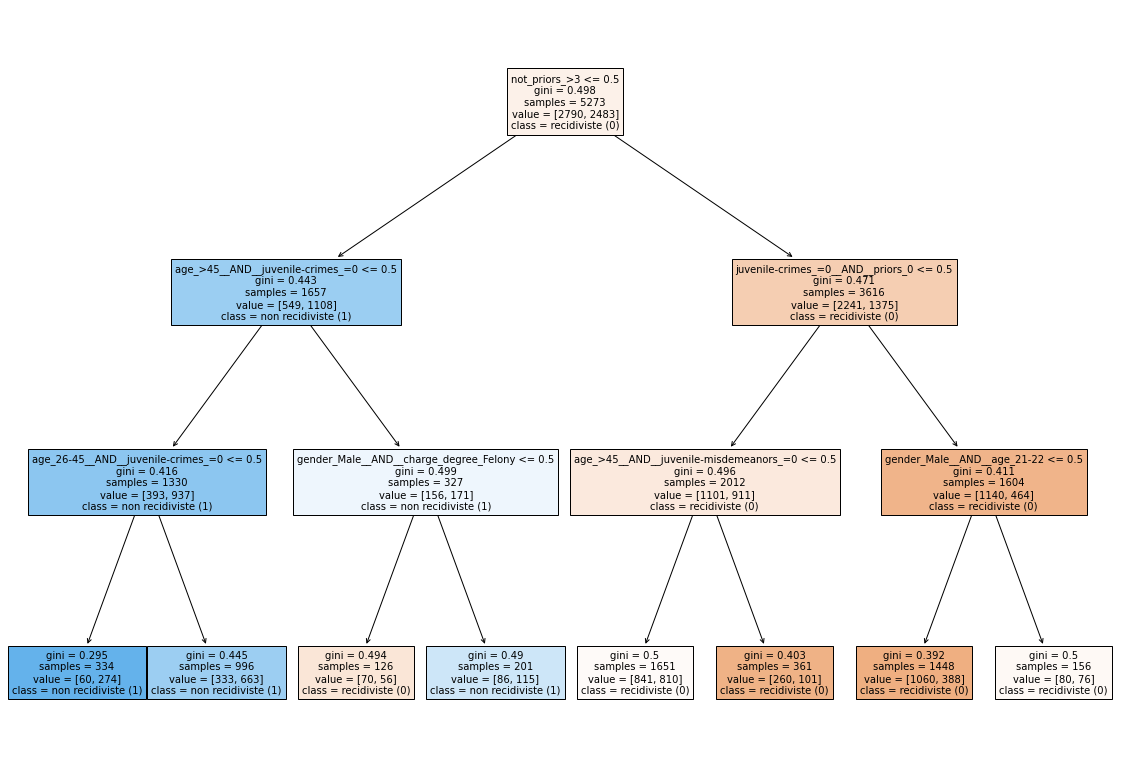

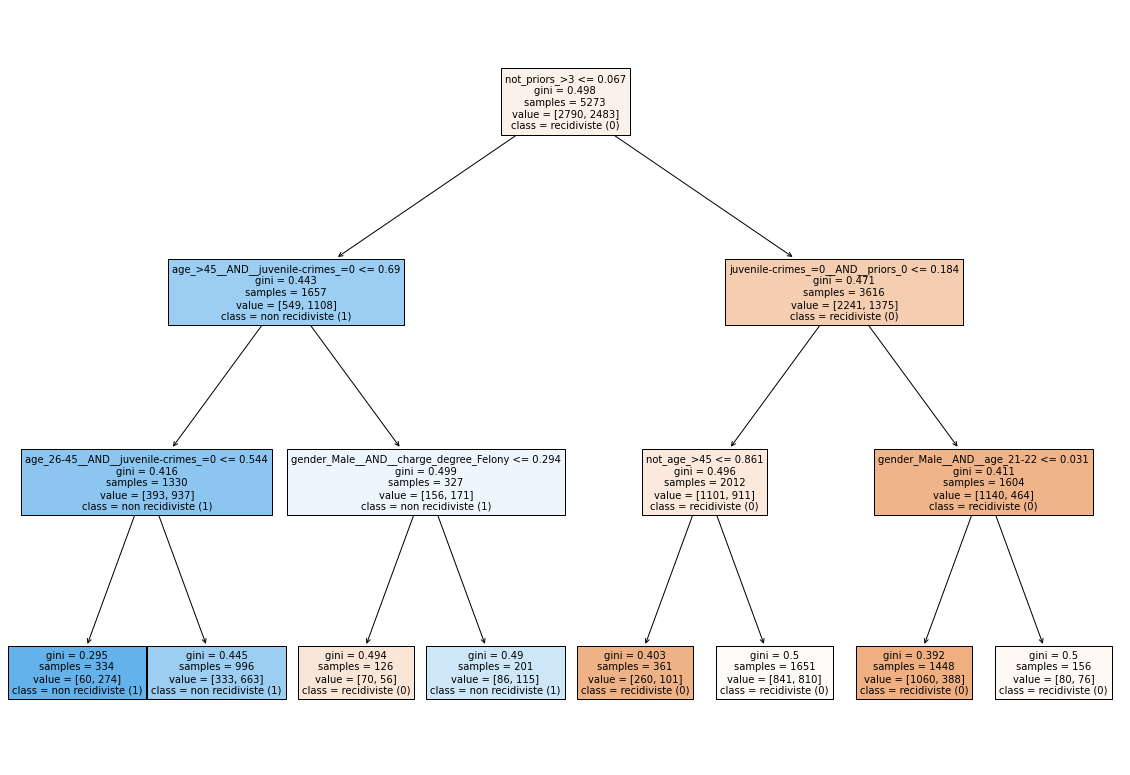

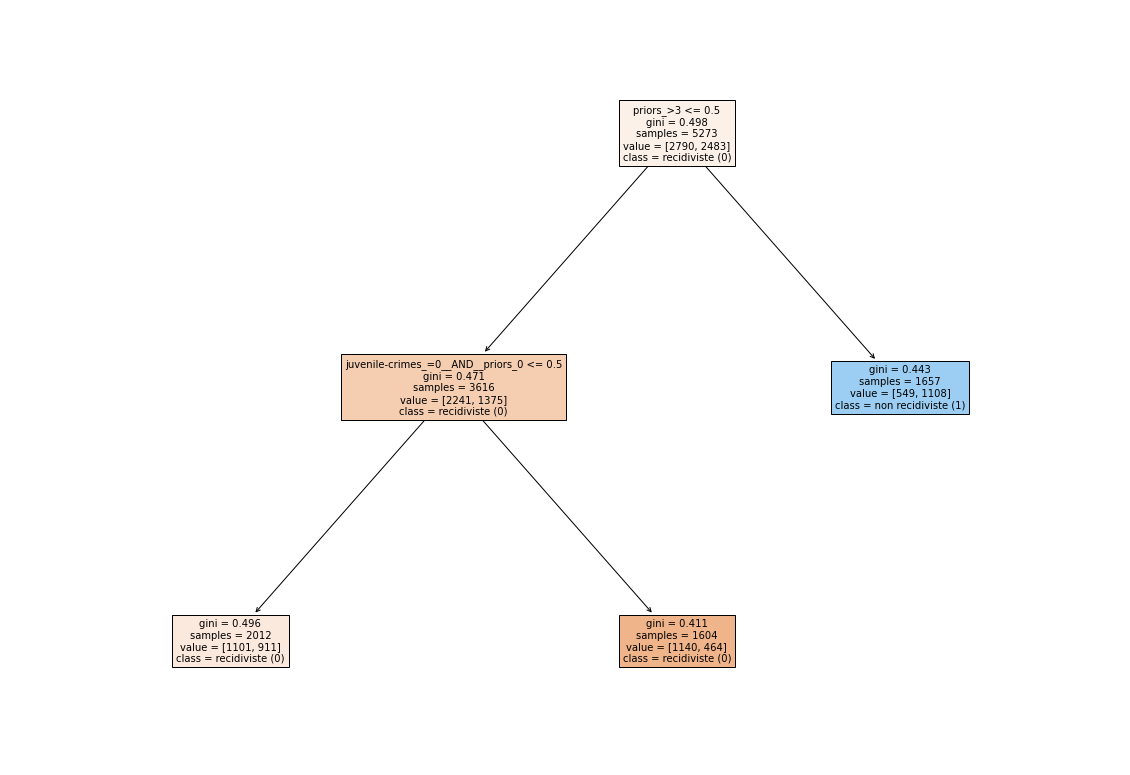

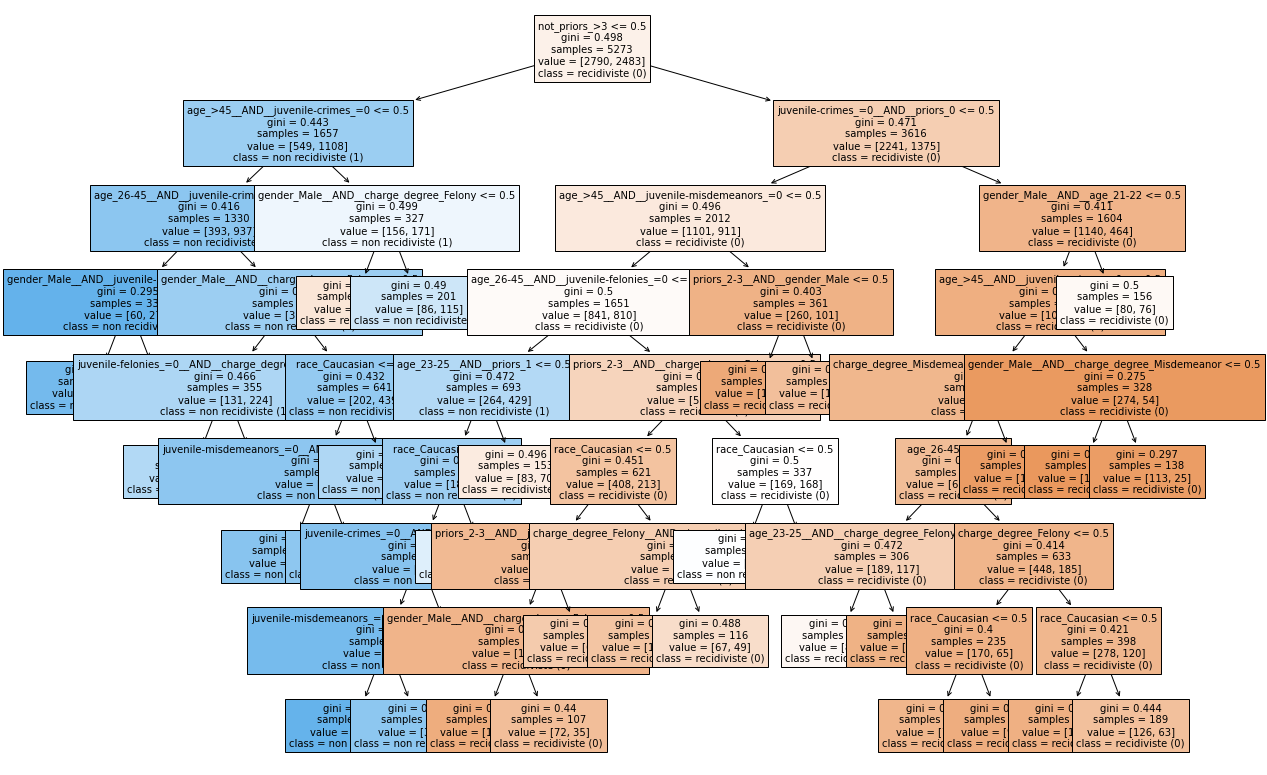

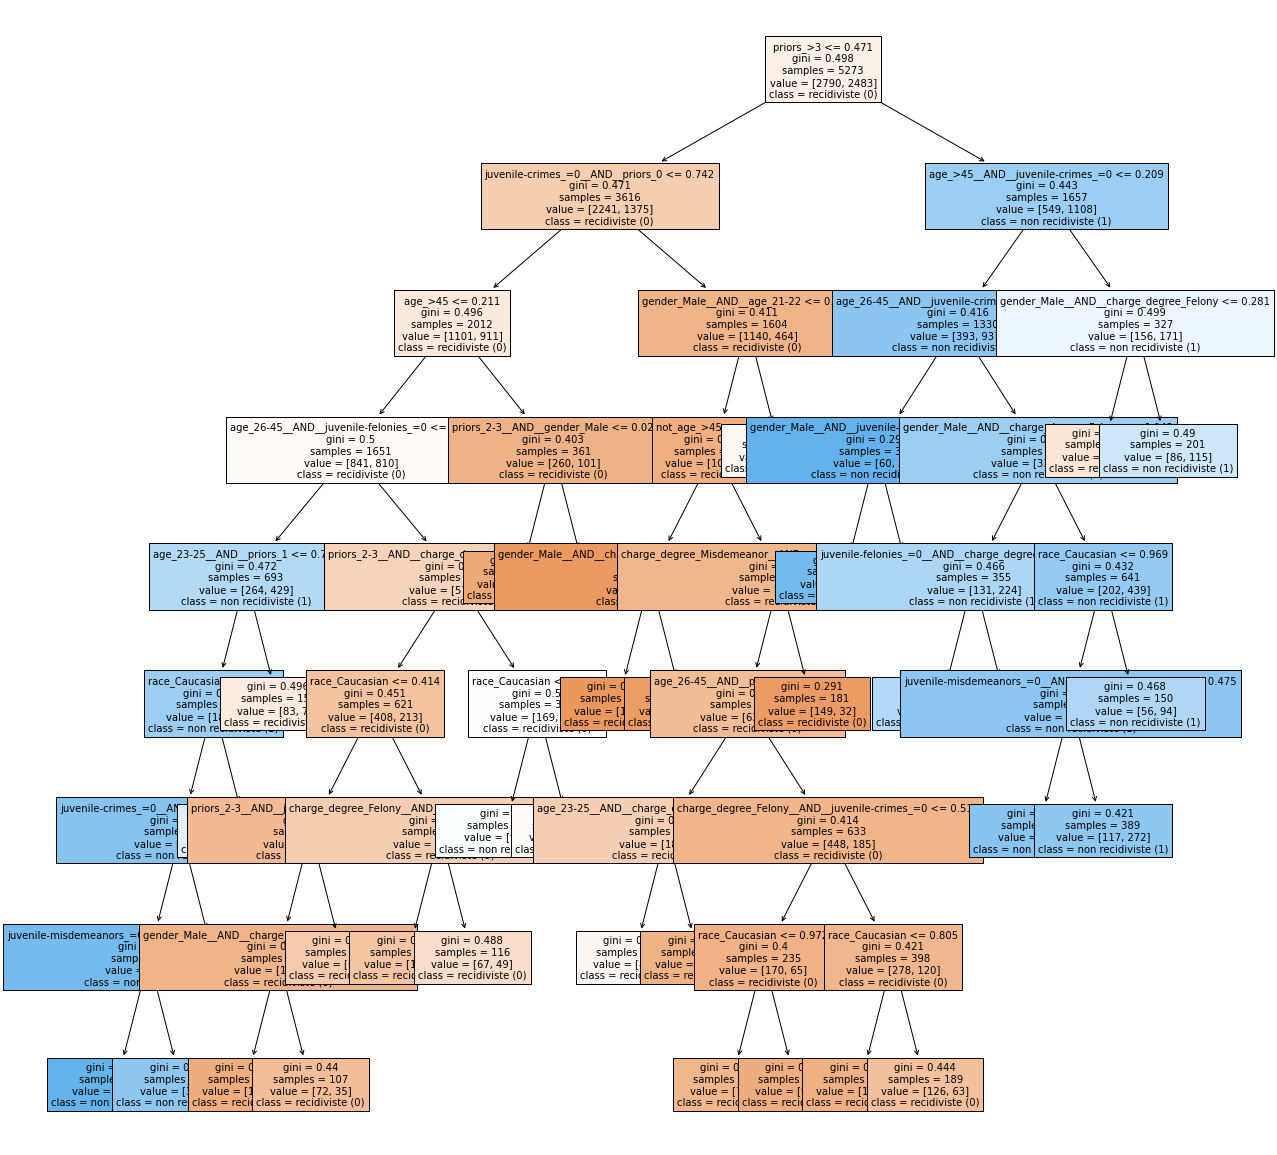

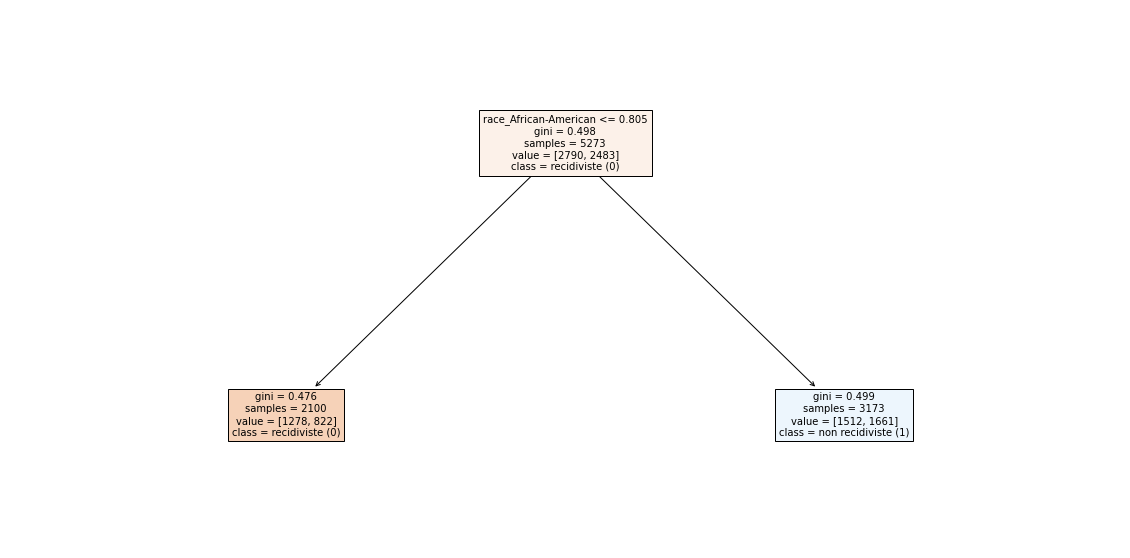

In [56]:
from sklearn import tree
from matplotlib import pyplot as plt # for a good visualization of the trees 
import csv
import numpy as np
from utils import load_from_csv

train_examples, train_labels, features, prediction = load_from_csv("./compass.csv")

conf1 = {"splitter" : "best", "max_depth" : 3, "min_samples_leaf" : 100}
conf2 = {"splitter" : "random", "max_depth" : 3, "min_samples_leaf" : 100}
conf3 = {"splitter" : "best", "max_depth" : 3, "min_samples_leaf" : 1000}
conf4 = {"splitter" : "best", "max_depth" : 10, "min_samples_leaf" : 100}
conf5 = {"splitter" : "random", "max_depth" : 10, "min_samples_leaf" : 100}
conf6 = {"splitter" : "random", "max_depth" : 1, "min_samples_leaf" : 2000}

clf1 = tree.DecisionTreeClassifier(**conf1)
clf1 = clf1.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,14))
_ = tree.plot_tree(clf1, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

clf2 = tree.DecisionTreeClassifier(**conf2)
clf2 = clf2.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,14))
_ = tree.plot_tree(clf2, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

clf3 = tree.DecisionTreeClassifier(**conf3)
clf3 = clf3.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,14))
_ = tree.plot_tree(clf3, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

clf4 = tree.DecisionTreeClassifier(**conf4)
clf4 = clf4.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,14))
_ = tree.plot_tree(clf4, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

clf5 = tree.DecisionTreeClassifier(**conf5)
clf5 = clf5.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,21))
_ = tree.plot_tree(clf5, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

clf6 = tree.DecisionTreeClassifier(**conf6)
clf6 = clf6.fit(train_examples, train_labels)

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf6, 
                   feature_names= features,
                   class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                   filled=True,
                   fontsize=10)

Train a decision tree for each of the previous configurations on the full dataset

In [54]:
import random as rd

def split_train_test(examples,labels,testing_pourcent=0.2):
    
    training = examples[:]
    training_label = labels[:]
    length = len(training)

    testing = []
    testing_label = []
    
    while(len(testing) <= length*testing_pourcent):
        i = rd.randint(0,len(training)-1)
        testing.append(training[i])
        training = np.delete(training, (i), axis=0)
        testing_label.append(training_label[i])
        training_label = np.delete(training_label, (i), axis=0)
    
    return(training,training_label,np.array(testing),np.array(testing_label))

def createTree(train,trainl,conf):
    clf = tree.DecisionTreeClassifier(**conf)
    clf = clf.fit(train, trainl)
    return clf

def evaluateTree(clf,test,testl):
    res = clf.predict(test)
    
    confmatrix = np.zeros((2,2))
    
    for prediction,real in zip(res,testl):
        
        if real == 1:
            if prediction == 1:
                confmatrix[0,0]+=1
            if prediction == 0:
                confmatrix[0,1]+=1
        if real == 0:
            if prediction == 1:
                confmatrix[1,0]+=1
            if prediction == 0:
                confmatrix[1,1]+=1
    
    return confmatrix

train,trainl,test,testl = split_train_test(train_examples, train_labels)

clf1 = createTree(train,trainl,conf1)
clf2 = createTree(train,trainl,conf2)
clf3 = createTree(train,trainl,conf3)
clf4 = createTree(train,trainl,conf4)
clf5 = createTree(train,trainl,conf5)
clf6 = createTree(train,trainl,conf6)

evaluateTree(clf6,test,testl)



array([[  0., 530.],
       [  0., 525.]])

Propose an evaluation in terms of training and testing accuracies using $5$-cross validation on two decision trees that have different typologies

In [57]:
def split_folds(examples,labels,Nfolds=5):
    length = int(len(examples)/Nfolds) #length of each fold
    folds = []
    foldsl = []
    for i in range(Nfolds-1):
        folds += [examples[i*length:(i+1)*length]]
        foldsl += [labels[i*length:(i+1)*length]]
    folds += [examples[(Nfolds-1)*length:len(examples)]]
    foldsl += [labels[(Nfolds-1)*length:len(labels)]]
    return folds,foldsl

def fivecross(conf,examples=train_examples,label=train_labels):
    folds,foldsl = split_folds(examples,label)
    confmatrix = np.zeros((2,2))
    for i in range(5):
        if i != 4:
            train = [j for k in (folds[:i] + folds[i+1:]) for j in k]
            trainl = [j for k in (foldsl[:i] + foldsl[i+1:]) for j in k]
        else:
            train = [j for k in folds[:i] for j in k]
            trainl = [j for k in foldsl[:i] for j in k]
        test = folds[i]
        testl = foldsl[i]
        
        clf = createTree(train,trainl,conf)
        confmatrix = confmatrix + evaluateTree(clf,test,testl)
    
    confmatrix = confmatrix/5
    
    return confmatrix

def evaluateConfMatrix(confmatrix):
    TP = 100*confmatrix[0,0]/(confmatrix[0,0]+confmatrix[0,1])
    TN = 100*confmatrix[1,1]/(confmatrix[1,0]+confmatrix[1,1])
    FP = 100-TP
    FN = 100 - TN
    print("True Positive Rate is : " + str(TP))
    print("False Positive Rate is : " + str(FP))
    print("True Negative Rate is : " + str(TN))
    print("False Negative Rate is : " + str(FN)+"\n")
    return (TP,FP,TN,FN)

fc1 = fivecross(conf1)
print("configuration : " + str(conf1))
e1 = evaluateConfMatrix(fc1)
fc2 = fivecross(conf5)
print("configuration : " + str(conf5))
e2 = evaluateConfMatrix(fc2)
        
            
    


configuration : {'splitter': 'best', 'max_depth': 3, 'min_samples_leaf': 100}
True Positive Rate is : 46.03302456705598
False Positive Rate is : 53.96697543294402
True Negative Rate is : 79.10394265232975
False Negative Rate is : 20.89605734767025

configuration : {'splitter': 'random', 'max_depth': 10, 'min_samples_leaf': 100}
True Positive Rate is : 60.531614981876764
False Positive Rate is : 39.468385018123236
True Negative Rate is : 71.18279569892474
False Negative Rate is : 28.817204301075265



Propose an experimental study that shows the transition phase from underfitting to overfitting 

Construct the confusion matrix on a particular good configuration (after explaining your choice)

Provide an evaluation of the fairness of the model based on the False Positive Rate